In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## CLUPI optical distortion

Reference:

[CLUPI FM Geometric Calibration](./doc/CLUPI_FM_GeometricCalibration_20190805_V1.0.pdf)

[Open CV optical distortion]( https://docs.opencv.org/2.4/doc/tutorials/calib3d/camera_calibration/camera_calibration.html#camera-calibration-with-opencv)

<img src="./img/clupi_fovs.png" width="100" title="CLUPI context" />



In [2]:
width = 2652
half_width = width/2
height = 1768
half_height = height/2


calibration_results = {

28E-2 : {
    'fx': 13616.126338849,
    'fy': 13616.126338849,
    'cx': 1048.9536340664,
    'cy':  693.43003744259,
   'distortion' : [
    0.90795278846644,
   -0.81549917806834,
   -0.015467154966426,
   -0.024081314487023,
   -0.021714843651652    
    ]
},


'100' : {
    'fx': 12979.313699206,
    'fy': 12979.313699206,
    'cx': 1059.0009439107,
    'cy': 716.27511432891,
    
   'distortion' : [
    0.90795278846644,
     0.82640045036451,
    -0.80990580903775,
    -0.013565578400063,
    -0.024481529915831,
    -0.020481752564741
    ]
},

'120' : {

    'fx': 13167.381556084,
    'fy': 13167.381556084,
    'cx': 1488.0073428712,
    'cy': 1090.7177140844,
   'distortion' : [
    0.90795278846644,
     0.84478595905046,
    -0.77452686325751,
     0.016311335023569,
     0.013922403608605,
     0.040406969232604
    ]
}
}





\begin{equation*} \rho = 1+ K_1r^2 + K_2r^4 + K_3r^6\end{equation*}
\begin{equation*} r^2 = x'^2 + y'^2 \end{equation*}
\begin{equation*} x" = x' \rho + 2P_1x'y' + P_2(r^2 + 2x'^2) \end{equation*}
\begin{equation*} y" = y' \rho + P_1(r^2 + 2y'^2) + 2P_2x'y' \end{equation*}


rho 1.0000000009161953 1.0178852127611129
xp -0.07703759556589647 0.11765801271707534
xpp -0.12364126988390813 0.06692242906626206
up -634.5615173686192 1960.1778831352847
h_dff -696.728853390427 -629.0498054106206
vert_dif -441.0375975091158 -408.43848800114733


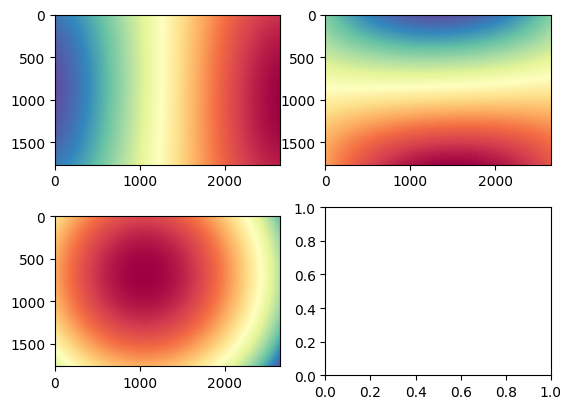

In [7]:

focal_distance = 28E-2
calibration = calibration_results[focal_distance]

k1, k2, p1, p2, k3 = calibration['distortion']

cx = calibration['cx']
cy = calibration['cy']

fx = calibration['fx']
fy = calibration['fy']

u, v = np.meshgrid(np.arange(0, width), np.arange(0, height))



xp =  (u - cx) / fx
yp =  (v - cy) / fy

r_2 = np.power(xp, 2) + np.power(yp, 2) 

rho = 1  + k1 * r_2  + k2 * np.power(r_2, 2) + k3 * np.power(r_2, 3)
print('rho', rho.min(), rho.max())
print('xp', xp.min(), xp.max())

htg_1 =  (2 * p1 * xp * yp) 
htg_2 =  (p2 * (r_2 + 2 * np.power(2, xp)))
xpp = (xp * rho) + htg_1 + htg_2
#ypp = yp * rho + (p1 * (r_2 + 2 * np.power(2, yp))) + (2 * p2 * xp * yp)

#xpp = xp * rho
vtg_1 =  (2 * p2 * xp * yp) 
vtg_2 =  (p1 * (r_2 + 2 * np.power(2, yp))) 
ypp = yp * rho + vtg_1 + vtg_2


up = (xpp * fx) + cx
vp = (ypp * fy) + cy

print('xpp', xpp.min(), xpp.max())
print('up', up.min(), up.max())


horiz_dif = up - u
print('h_dff', horiz_dif.min(), horiz_dif.max())

vert_dif = vp - v
print('vert_dif', vert_dif.min(), vert_dif.max())

cmap_name = 'Spectral'
fig, ((subplot_1, subplot_2), (subplot_3, subplot_4)) = plt.subplots(2, 2)
subplot_1.imshow(horiz_dif, cmap=cmap_name)
subplot_2.imshow(vert_dif, cmap=cmap_name)
subplot_3.imshow(r_2, cmap=cmap_name)

